# Почему пользователи не заканчивают курс?

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
sns.set(rc={'figure.figsize': (9, 6)})

In [4]:
# Анализ активности студентов онлайн курса "Введение в анализ данных в R" на https://stepik.org/

# Проблема:

# Много людей начинают проходить курс, мало заканчивают. Средний success rate 5-10%.
# Понять почему пользователи бросают курс и как сделать так, чтобы его не бросали.
# Предсказать уйдет ли пользователь с курса.
# Если пользователь собирается уйти, что надо сделать, чтобы он не ушел?

# Не меняя значительно курс, что можно исправить, чтобы добиться более высокого success rate?
# Проанализируем поведение студентов.
# Посмотрим как они проходят курс, как часто они его проходят. На каких степах были проблемы.
# Какие патерны и действия приводят к тому, что пользователь не доходит до конца.
# Какие наоборот приводят к тому, что он доходит.

# Как эту информацию можно использовать в дальнейшем, чтобы улучшить контент, улучшить продукт, увеличить метрику.

# Будем решать задачу классификации, студентов разделим на 2 класса - "не закончили курс", "закончили курс".
# Если мы обучим некоторую модель, которая начнет успешно предсказывать в самом начале пути студента,
# например, по его активности в течение первых нескольких дней закончит он курс или нет,
# это знание можно использовать, чтобы студента как-то направить в нужное русло.

In [5]:
# event_data_train - действия, которые совершают студенты со стэпами.

#   step_id   - ID стэпа
#   user_id   - анонимизированный id юзера
#   timestamp - время наступления события в формате unix date
#   action    - событие, возможные значения:

#     discovered      - пользователь перешел на стэп
#     viewed          - просмотр шага
#     started_attempt - начало попытки решить шаг
#     passed          - удачное решение практического шага

events = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')
events

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [6]:
# submissions_data_train - данные о времени и статусах сабмитов к практическим заданиям.

#   step_id           - ID стэпа
#   timestamp         - время отправки решения в формате unix date
#   submission_status - статус решения
#   user_id           - анонимизированный id юзера

submissions = pd.read_csv(
    'https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression ='zip'
)
submissions

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


## Убедимся, что данные валидны

In [7]:
# Убедимся, что значения action соответствуют описанным в ТЗ:
events.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [8]:
# Добавим человеко-понятную дату:
events['date'] = pd.to_datetime(events.timestamp, unit='s')
events['date'] = events.date.dt.date

submissions['date'] = pd.to_datetime(submissions.timestamp, unit='s')
submissions['date'] = submissions.date.dt.date

In [9]:
events

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15
...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19


In [10]:
submissions

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15
...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06


In [11]:
# Дата старта курса:
events.date.min()

datetime.date(2015, 6, 15)

In [12]:
# Максимальное значение:
events.date.max()

# Данные в выборке представлены почти за 3 года.

datetime.date(2018, 5, 19)

In [13]:
# "Сегодняшний" таймстемп (мы как будто находимся в 2018 году, 19-го мая выгрузили данные):
now = events.timestamp.max()
now

1526772811

In [14]:
# Посмотрим количество уникальных юзеров, которые делали какие-то действия в каждый из дней:
events.groupby('date').user_id.nunique()

date
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
             ... 
2018-05-15    145
2018-05-16    155
2018-05-17    165
2018-05-18    126
2018-05-19    131
Name: user_id, Length: 1070, dtype: int64

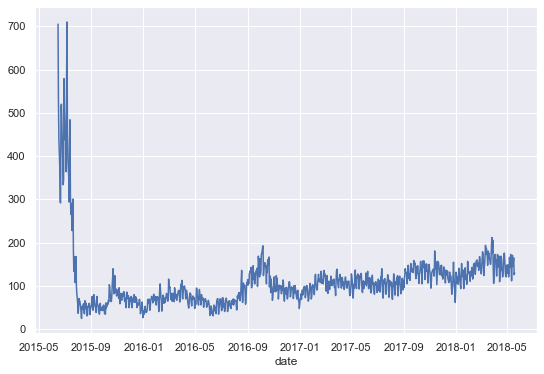

In [15]:
# Визуализируем (ось x - день, ось y - количество).
# Не наблюдаем каких-то выбросов или пропусков данных, делаем вывод, что по времени нет каких-либо проблем.
events.groupby('date').user_id.nunique().plot().autoscale(tight=False)

In [16]:
# Как распределены пользователи по количеству баллов, которое они набрали за курс:
user_events = events.pivot_table(
    index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)

user_events

,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


<AxesSubplot:>

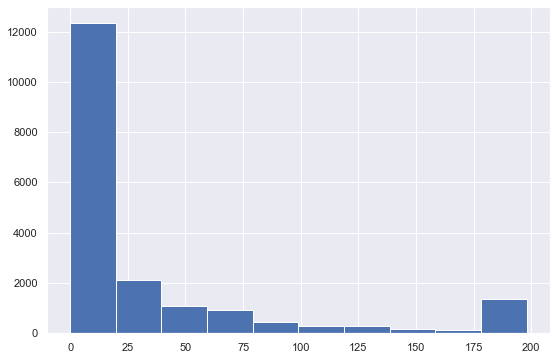

In [17]:
# Ось x - количество решенных задач, ось y - количество пользователей:
user_events.passed.hist()

<AxesSubplot:>

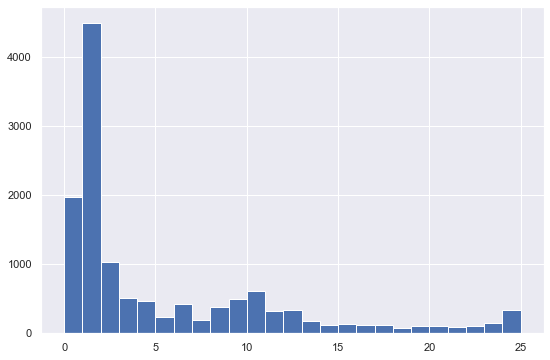

In [18]:
# Около 2000 учащихся не решили ни одной задачи:
user_events.query('passed <= 25').passed.hist(bins=25)

In [19]:
# 1972 пользователя, если быть точным:
user_events.query('passed == 0').shape[0]

1972

In [20]:
# Правильные и неправильные ответы пользователей:
user_submissions = submissions.pivot_table(
    index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)

user_submissions

,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [21]:
# Сколько уникальных дней учились пользователи:
unique_days = events.groupby('user_id').date.nunique().to_frame() \
    .rename(columns={'date': 'unique_days'})

unique_days

,unique_days
user_id,
1,1
2,2
3,7
5,2
7,1
...,...
26790,4
26793,1
26794,9


<AxesSubplot:>

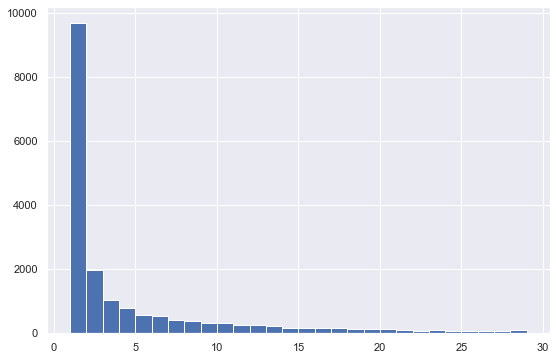

In [22]:
# Визуализируем:
unique_days.query('unique_days < 30').unique_days.hist(bins=28)

In [23]:
# 50% были на курсе один день и больше никогда не заходили.
# 30% учились 5 уникальных дней и более.
unique_days.describe(percentiles=[.51, .6, .61, .66, .67, .7, .71, .73, .74, .75, .76, .78, .79])

,unique_days
count,19234.000000
mean,6.088489
std,12.341683
min,1.000000
50%,1.000000
51%,2.000000
60%,2.000000
61%,3.000000
66%,3.000000
67%,4.000000


## Каких пользователей считаем прошедшими курс?

In [24]:
# Чтобы получить сертификат, надо решить 170 задач.
# Получил сертификат - значит прошел курс.
PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE = 170

In [25]:
# Посмотрим количество пройденных практических шагов:
users = user_events[['user_id', 'passed']].rename(columns={'passed': 'passed_practical_steps'})
users

,user_id,passed_practical_steps
0,1,0
1,2,9
2,3,87
3,5,11
4,7,1
...,...,...
19229,26790,8
19230,26793,0
19231,26794,69
19232,26797,10


In [26]:
# Добавим флаг, прошел ли пользователь курс:
users['passed_course'] = users.passed_practical_steps >= PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE
users.passed_course = users.passed_course.map(int)
users

,user_id,passed_practical_steps,passed_course
0,1,0,0
1,2,9,0
2,3,87,0
3,5,11,0
4,7,1,0
...,...,...,...
19229,26790,8,0
19230,26793,0,0
19231,26794,69,0
19232,26797,10,0


In [27]:
# Узнаем время первого захода на курс:
first_visits = events.groupby('user_id').timestamp.min().to_frame().rename(columns={'timestamp': 'first_visit'})
first_visits

,first_visit
user_id,
1,1472827464
2,1514383364
3,1434358476
5,1466156809
7,1521634660
...,...
26790,1451484016
26793,1510225031
26794,1495287049


In [28]:
# И время последнего захода на курс:
last_visits = events.groupby('user_id').timestamp.max().to_frame().rename(columns={'timestamp': 'last_visit'})
last_visits

,last_visit
user_id,
1,1472827464
2,1519226966
3,1444581588
5,1499859939
7,1521634660
...,...
26790,1517495987
26793,1510225034
26794,1512035039


In [29]:
# Добавим первый и последний заходы на курс:
users = users.merge(first_visits, on='user_id')
users = users.merge(last_visits, on='user_id')
users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit
0,1,0,0,1472827464,1472827464
1,2,9,0,1514383364,1519226966
2,3,87,0,1434358476,1444581588
3,5,11,0,1466156809,1499859939
4,7,1,0,1521634660,1521634660
...,...,...,...,...,...
19229,26790,8,0,1451484016,1517495987
19230,26793,0,0,1510225031,1510225034
19231,26794,69,0,1495287049,1512035039
19232,26797,10,0,1508425316,1509995096


In [30]:
# Количественное соотношение прошедших и непрошедших курс:
users.passed_course.value_counts()

0    17801
1     1433
Name: passed_course, dtype: int64

In [31]:
# Процентное соотношение прошедших и непрошедших курс:
users.passed_course.value_counts(normalize=True)

0    0.925497
1    0.074503
Name: passed_course, dtype: float64

<AxesSubplot:xlabel='passed_course', ylabel='count'>

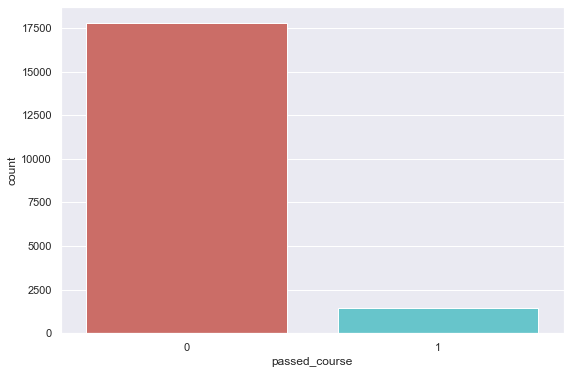

In [33]:
# Визуализируем количество закончивших и незакончивших курс:
sns.countplot(x='passed_course', data=users, palette='hls')

## Каких пользователей считаем ушедшими с курса?

In [34]:
# Надо понять, пользователи без сертификата еще учатся или уже бросили курс?

# Попробуем 2 подхода:

# 1.
# Изучим длительность обучения пользователей, получивших сертификат.
# Возьмем максимальное количество дней или какой-нибудь 99 персентиль в качестве "порога длительности обучения".
# Если пользователь без сертификата учится дольше, чем порог - считаем что он бросил курс.

# 2.
# Изучим перерывы в обучении у пользователей, получивших сертификат.
# Возьмем максимальный перерыв или какой-нибудь 99 персентиль в качестве "порога длительности отсутствия".
# Если от последнего событитя пользователя до сегодняшнего дня прошло больше времени, чем порог
# - считаем что он бросил курс.

### Длительность обучения получивших сертификат

In [35]:
# ID прошедших курс пользователей:
passed_course_user_ids = users[users['passed_course'] == True].user_id
passed_course_user_ids

9           16
13          22
18          30
22          34
26          39
         ...  
19190    26740
19207    26763
19218    26777
19220    26779
19221    26781
Name: user_id, Length: 1433, dtype: int64

In [36]:
# Отберем события пользователей, прошедших курс:
events_of_passed_course_users = events[events['user_id'].isin(passed_course_user_ids)]
events_of_passed_course_users

,step_id,timestamp,action,user_id,date
94,32815,1434342230,discovered,6646,2015-06-15
95,32815,1434342230,passed,6646,2015-06-15
96,32815,1434342230,viewed,6646,2015-06-15
97,32811,1434342233,passed,6646,2015-06-15
98,32811,1434342233,discovered,6646,2015-06-15
...,...,...,...,...,...
3479642,34026,1526756104,viewed,23194,2018-05-19
3479644,33901,1526756106,viewed,23194,2018-05-19
3479652,33901,1526756195,viewed,23194,2018-05-19
3479653,33899,1526756197,viewed,23194,2018-05-19


In [37]:
# Узнаем время правильного решения 170-й задачи. Это и будет время окончания курса.
# Для этого соберем датафрейм из первых 170-ти событий успешного решения практического шага:
tmp = events_of_passed_course_users.query('action == "passed"') \
    .sort_values(['user_id', 'timestamp']) \
    .groupby('user_id') \
    .head(PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE)

tmp.head(PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE + 1)

,step_id,timestamp,action,user_id,date
282352,32815,1435674765,passed,16,2015-06-30
282363,32811,1435674778,passed,16,2015-06-30
282380,32929,1435674798,passed,16,2015-06-30
282385,32814,1435674800,passed,16,2015-06-30
282417,32812,1435674880,passed,16,2015-06-30
...,...,...,...,...,...
2826977,33983,1513093702,passed,16,2017-12-12
2826983,33984,1513093777,passed,16,2017-12-12
2827047,34041,1513094276,passed,16,2017-12-12
2827052,33939,1513094298,passed,16,2017-12-12


In [38]:
# Максимальный таймстемп каждого пользователя - это время получения сертификата:
obtaining_certs = tmp.groupby('user_id').timestamp.max().to_frame() \
    .rename(columns={'timestamp': 'obtaining_cert'})

obtaining_certs

,obtaining_cert
user_id,
16,1513094298
22,1500036463
30,1509095682
34,1504794582
39,1459445025
...,...
26740,1456347416
26763,1436205266
26777,1436462092


In [39]:
# Создадим датафрейм, поместим туда прошедших курс пользователей:
passed_course_users = users.query('passed_course == True')

# Добавим время получения сертификата:
passed_course_users = passed_course_users.merge(obtaining_certs, on='user_id')

passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,obtaining_cert
0,16,196,1,1435674765,1513162585,1513094298
1,22,198,1,1498561010,1507142631,1500036463
2,30,198,1,1467307716,1510574287,1509095682
3,34,195,1,1493156230,1525626844,1504794582
4,39,198,1,1456943480,1502712399,1459445025
...,...,...,...,...,...,...
1428,26740,188,1,1444388456,1463224362,1456347416
1429,26763,193,1,1434350514,1436216740,1436205266
1430,26777,191,1,1434374498,1436605200,1436462092
1431,26779,196,1,1473155734,1520157100,1476952592


In [40]:
# Узнаем, за сколько дней пользователи прошли курс:
passed_course_users['days_spent_on_obtaining_cert'] = \
    np.ceil(
        (passed_course_users['obtaining_cert'] - passed_course_users['first_visit']) / (24 * 60 * 60)
    ).map(int)
    
passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert
0,16,196,1,1435674765,1513162585,1513094298,897
1,22,198,1,1498561010,1507142631,1500036463,18
2,30,198,1,1467307716,1510574287,1509095682,484
3,34,195,1,1493156230,1525626844,1504794582,135
4,39,198,1,1456943480,1502712399,1459445025,29
...,...,...,...,...,...,...,...
1428,26740,188,1,1444388456,1463224362,1456347416,139
1429,26763,193,1,1434350514,1436216740,1436205266,22
1430,26777,191,1,1434374498,1436605200,1436462092,25
1431,26779,196,1,1473155734,1520157100,1476952592,44


<AxesSubplot:>

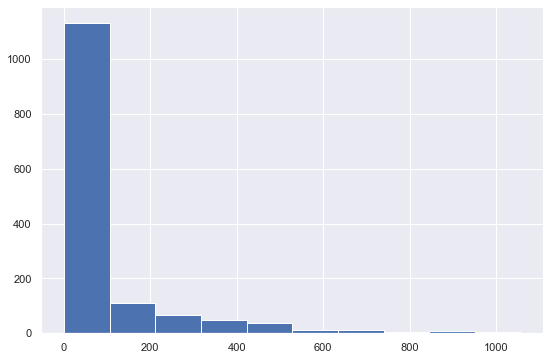

In [41]:
# Ось x - количество дней, ось y - количество учеников:
passed_course_users['days_spent_on_obtaining_cert'].hist()

<AxesSubplot:>

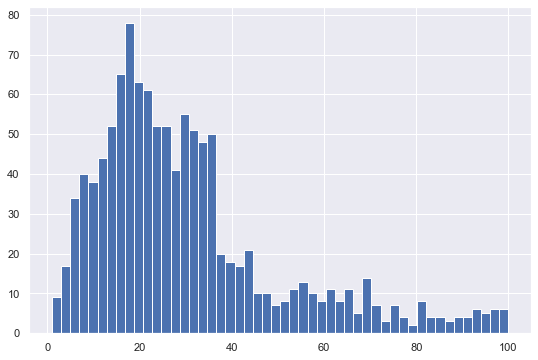

In [42]:
# Посмотрим подробнее первую сотню:
passed_course_users.query('days_spent_on_obtaining_cert <= 100').days_spent_on_obtaining_cert.hist(bins=50)

In [43]:
# Наблюдаем очень быстрое прохождение курса у 8-ми пользователей.
# Если не переводить значение в целые дни, то там будет от 30 до 45 мин у первых 8-ми пользователей.
# Может команда курса тестировала?
passed_course_users.sort_values('days_spent_on_obtaining_cert').head(10)

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert
519,9104,195,1,1522098760,1522183769,1522111098,1
957,17191,190,1,1455013305,1458322391,1455024723,1
625,11061,196,1,1521015150,1523169005,1521017255,1
1138,21010,181,1,1482449434,1482475233,1482475149,1
564,9956,184,1,1463316278,1463380111,1463318306,1
1077,19805,198,1,1509741291,1512210943,1509744324,1
1220,22833,194,1,1464164406,1517842929,1464166049,1
651,11574,185,1,1478609068,1478629364,1478629003,1
248,4106,193,1,1458310371,1458484260,1458473308,2
1180,22059,197,1,1514928356,1515238451,1515182835,3


In [44]:
passed_course_users['days_spent_on_obtaining_cert'].describe(percentiles=[.9, .95, .99])

# Сколько дней обучения брать в качестве порога?

# Например, считаем, что пользователь бросил курс,
# если он не получил сертификат и уже учится более 434 дней (95 персентиль).

# Пользователи, которые не имеют сертификат и учатся меньше 434 дней, будут в неопределенном статусе.
# Посмотрим, сколько таких пользователей будет при взятии различных порогов.

count    1433.000000
mean       92.387299
std       152.200695
min         1.000000
50%        31.000000
90%       283.800000
95%       434.000000
99%       747.440000
max      1056.000000
Name: days_spent_on_obtaining_cert, dtype: float64

In [45]:
# Пользователи без сертификатов:
not_passed_course_users = users.query('passed_course == False')
not_passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit
0,1,0,0,1472827464,1472827464
1,2,9,0,1514383364,1519226966
2,3,87,0,1434358476,1444581588
3,5,11,0,1466156809,1499859939
4,7,1,0,1521634660,1521634660
...,...,...,...,...,...
19229,26790,8,0,1451484016,1517495987
19230,26793,0,0,1510225031,1510225034
19231,26794,69,0,1495287049,1512035039
19232,26797,10,0,1508425316,1509995096


In [46]:
training_length_threshold = 747 * 24 * 60 * 60

# 11417 человек  начали проходить курс меньше чем 747 дня назад (99-й персентиль).
# 7530  человека начали проходить курс меньше чем 434 дня назад (95-й персентиль).
not_passed_course_users.query('first_visit + @training_length_threshold > @now').shape[0]

11417

In [47]:
# Мы потеряем 59.3% пользователей без сертификата в случае взятия 99-го персентиля в качестве порога.
# т.к. они не закончили курс и не бросили его.
# Мы потеряем 39.1% пользователей без сертификата в случае взятия 95-го персентиля в качестве порога.
not_passed_course_users.query('first_visit + @training_length_threshold > @now').shape[0] / users.shape[0]

0.5935842778413226

### Перерывы в обучении у получивших сертификат

In [48]:
# Добавим время получения сертификата к событиям пользователей получивших сертификат:
events_of_passed_course_users = events_of_passed_course_users.merge(
    passed_course_users[['user_id', 'obtaining_cert']], on='user_id'
)

events_of_passed_course_users

,step_id,timestamp,action,user_id,date,obtaining_cert
0,32815,1434342230,discovered,6646,2015-06-15,1437414247
1,32815,1434342230,passed,6646,2015-06-15,1437414247
2,32815,1434342230,viewed,6646,2015-06-15,1437414247
3,32811,1434342233,passed,6646,2015-06-15,1437414247
4,32811,1434342233,discovered,6646,2015-06-15,1437414247
...,...,...,...,...,...,...
1486108,34052,1525605372,viewed,5573,2018-05-06,1525378349
1486109,32815,1525720779,viewed,5573,2018-05-07,1525378349
1486110,32927,1525720783,viewed,5573,2018-05-07,1525378349
1486111,32191,1525720784,viewed,5573,2018-05-07,1525378349


In [49]:
# Для каждого пользователя получим максимальный перерыв между событиями до получения сертификата:
max_breaks_of_passed_course_users = events_of_passed_course_users \
    .query('timestamp <= obtaining_cert')[['user_id', 'timestamp']] \
    .groupby('user_id')['timestamp'] \
    .apply(list) \
    .apply(np.diff) \
    .apply(np.max) \
    .to_frame().rename(columns={'timestamp': 'max_break'})

max_breaks_of_passed_course_users

,max_break
user_id,
16,61161049
22,263487
30,12567375
34,4938396
39,266880
...,...
26740,8181317
26763,366338
26777,561426


In [50]:
# Переведем секунды в дни:
max_breaks_of_passed_course_users['max_break'] = \
    np.ceil(
        max_breaks_of_passed_course_users['max_break'] / (24 * 60 * 60)
    ).map(int)

max_breaks_of_passed_course_users

,max_break
user_id,
16,708
22,4
30,146
34,58
39,4
...,...
26740,95
26763,5
26777,7


In [51]:
# Добавим максимальный перерыв между событиями к пользователям, получившим сетрификат:
passed_course_users = passed_course_users.merge(max_breaks_of_passed_course_users, on='user_id')
passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert,max_break
0,16,196,1,1435674765,1513162585,1513094298,897,708
1,22,198,1,1498561010,1507142631,1500036463,18,4
2,30,198,1,1467307716,1510574287,1509095682,484,146
3,34,195,1,1493156230,1525626844,1504794582,135,58
4,39,198,1,1456943480,1502712399,1459445025,29,4
...,...,...,...,...,...,...,...,...
1428,26740,188,1,1444388456,1463224362,1456347416,139,95
1429,26763,193,1,1434350514,1436216740,1436205266,22,5
1430,26777,191,1,1434374498,1436605200,1436462092,25,7
1431,26779,196,1,1473155734,1520157100,1476952592,44,8


<AxesSubplot:>

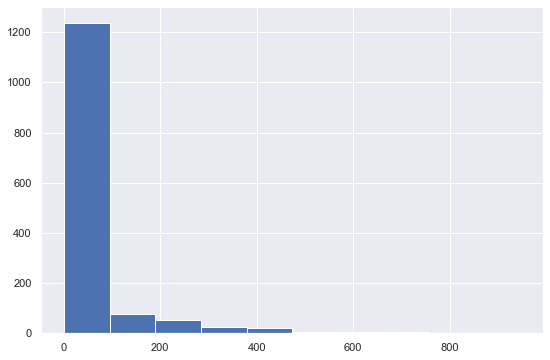

In [52]:
passed_course_users['max_break'].hist()

In [53]:
passed_course_users['max_break'].describe(percentiles=[.9, .95, .99])

# Какой максимальный перерыв брать в качестве порога?
# Посмотрим, сколько пользователей мы "потеряем" при взятии различных порогов.

count    1433.000000
mean       48.413119
std       107.147067
min         1.000000
50%         8.000000
90%       144.000000
95%       274.600000
99%       536.680000
max       947.000000
Name: max_break, dtype: float64

### Перерывы при проходжением курса у НЕ получивших сертификат

In [54]:
# ID пользователей без сертификата:
not_passed_course_user_ids = users.query('passed_course == False').user_id
not_passed_course_user_ids

0            1
1            2
2            3
3            5
4            7
         ...  
19229    26790
19230    26793
19231    26794
19232    26797
19233    26798
Name: user_id, Length: 17801, dtype: int64

In [55]:
# Отберем события пользователей без сертификата:
events_of_not_passed_course_users = events[events['user_id'].isin(not_passed_course_user_ids)]
events_of_not_passed_course_users

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15
...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19


In [56]:
# Получим максимальный перерыв между событиями для каждого пользователя без сертификата.
# Время от последнего события пользователя до "сегодняшнего" момента тоже надо учесть:
max_breaks_of_not_passed_course_users = events_of_not_passed_course_users[['user_id', 'timestamp']] \
    .groupby('user_id')['timestamp'] \
    .apply(list) \
    .apply(lambda x: x + [now]) \
    .apply(np.diff) \
    .apply(np.max) \
    .to_frame().rename(columns={'timestamp': 'max_break'})

max_breaks_of_not_passed_course_users

,max_break
user_id,
1,53945347
2,7545845
3,82191223
5,33702812
7,5138151
...,...
26790,64879648
26793,16547777
26794,14737772


In [57]:
# Переведем секунды в дни:
max_breaks_of_not_passed_course_users['max_break'] = \
    np.ceil(
        max_breaks_of_not_passed_course_users['max_break'] / (24 * 60 * 60)
    ).map(int)

max_breaks_of_not_passed_course_users

,max_break
user_id,
1,625
2,88
3,952
5,391
7,60
...,...
26790,751
26793,192
26794,171


In [58]:
# Добавим максимальный перерыв к пользователям без сертификата:
not_passed_course_users = not_passed_course_users.merge(max_breaks_of_not_passed_course_users, on='user_id')
not_passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,max_break
0,1,0,0,1472827464,1472827464,625
1,2,9,0,1514383364,1519226966,88
2,3,87,0,1434358476,1444581588,952
3,5,11,0,1466156809,1499859939,391
4,7,1,0,1521634660,1521634660,60
...,...,...,...,...,...,...
17796,26790,8,0,1451484016,1517495987,751
17797,26793,0,0,1510225031,1510225034,192
17798,26794,69,0,1495287049,1512035039,171
17799,26797,10,0,1508425316,1509995096,195


In [59]:
breaks_in_training_threshold = 536

# 9473 человека без сертификата имеют максимальный перерыв менее 536 дней (99-й персентиль). 
# 6109  человек без сертификата имеют максимальный перерыв менее 274 дней (95-й персентиль).
not_passed_course_users.query('max_break <= @breaks_in_training_threshold').shape[0]

9473

In [60]:
# Мы потеряем 53.2% пользователей без сертификата если возьмем 99-й персентиль в качестве порога,
# т.к. они не закончили курс, но и не бросили его.
# Мы потеряем 34.3% пользователей без сертификата если возьмем 95-й персентиль в качестве порога.
not_passed_course_users.query('max_break <= @breaks_in_training_threshold').shape[0] \
    / not_passed_course_users.shape[0]

0.5321611145441267

## Отметим, кто покинул курс

In [61]:
# Возьмем в качестве порога значение из 2-го подхода 99 персентиль.
# Т.е. если пользователь не имеет сертификата и отсутствует(отсутствовал) на платформе более 536 дней,
# считаем, что он покинул курс.
breaks_in_training_threshold

536

In [62]:
# Добавим ко всем пользователям максимальный перерыв:
users = users.merge(
    pd.concat([max_breaks_of_passed_course_users, max_breaks_of_not_passed_course_users]),
    on='user_id'
)

users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,max_break
0,1,0,0,1472827464,1472827464,625
1,2,9,0,1514383364,1519226966,88
2,3,87,0,1434358476,1444581588,952
3,5,11,0,1466156809,1499859939,391
4,7,1,0,1521634660,1521634660,60
...,...,...,...,...,...,...
19229,26790,8,0,1451484016,1517495987,751
19230,26793,0,0,1510225031,1510225034,192
19231,26794,69,0,1495287049,1512035039,171
19232,26797,10,0,1508425316,1509995096,195


In [63]:
# Отметим покинувших курс пользователей:
users['is_gone'] = 0
users.loc[(users['passed_course'] == 0) & (users['max_break'] > breaks_in_training_threshold), 'is_gone'] = 1
users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,max_break,is_gone
0,1,0,0,1472827464,1472827464,625,1
1,2,9,0,1514383364,1519226966,88,0
2,3,87,0,1434358476,1444581588,952,1
3,5,11,0,1466156809,1499859939,391,0
4,7,1,0,1521634660,1521634660,60,0
...,...,...,...,...,...,...,...
19229,26790,8,0,1451484016,1517495987,751,1
19230,26793,0,0,1510225031,1510225034,192,0
19231,26794,69,0,1495287049,1512035039,171,0
19232,26797,10,0,1508425316,1509995096,195,0


In [64]:
# Посмотрим комбинации количества учащихся, прошедших курс и покинувших курс:
users.groupby(['passed_course', 'is_gone'])['user_id'].count()

passed_course  is_gone
0              0          9473
               1          8328
1              0          1433
Name: user_id, dtype: int64

In [65]:
# Удалим пользователей в "неопределенном" статусе, которые и не прошли курс, и не успели его бросить:
users = users[(users['is_gone'] == True) | (users['passed_course'] == True)]
users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,max_break,is_gone
0,1,0,0,1472827464,1472827464,625,1
2,3,87,0,1434358476,1444581588,952,1
8,14,3,0,1436366155,1436368676,1047,1
9,16,196,1,1435674765,1513162585,708,0
10,17,5,0,1465762612,1465765342,707,1
...,...,...,...,...,...,...,...
19220,26779,196,1,1473155734,1520157100,8,0
19221,26781,198,1,1487693786,1507540704,20,0
19223,26783,10,0,1434542952,1434543274,1068,1
19228,26789,2,0,1447263411,1447263419,921,1


In [66]:
# Проверим комбинации количества учащихся, прошедших курс и покинувших курс:
users.groupby(['passed_course', 'is_gone'])['user_id'].count()

passed_course  is_gone
0              1          8328
1              0          1433
Name: user_id, dtype: int64

In [67]:
# Мы удалили из выборки 9473 пользователя, поэтому изменился дисбаланс классов.
# Процентное соотношение прошедших и непрошедших курс:
users['passed_course'].value_counts(normalize=True)

# А было соотношение 92.5 на 7.5

0    0.853191
1    0.146809
Name: passed_course, dtype: float64

In [68]:
# Колонка "is_gone" - полная противоположность колонки "passed_course".
# Будем предсказывать именно ушедщих с курса:
users = users.drop('passed_course', axis=1)
users

,user_id,passed_practical_steps,first_visit,last_visit,max_break,is_gone
0,1,0,1472827464,1472827464,625,1
2,3,87,1434358476,1444581588,952,1
8,14,3,1436366155,1436368676,1047,1
9,16,196,1435674765,1513162585,708,0
10,17,5,1465762612,1465765342,707,1
...,...,...,...,...,...,...
19220,26779,196,1473155734,1520157100,8,0
19221,26781,198,1487693786,1507540704,20,0
19223,26783,10,1434542952,1434543274,1068,1
19228,26789,2,1447263411,1447263419,921,1


<AxesSubplot:xlabel='is_gone', ylabel='count'>

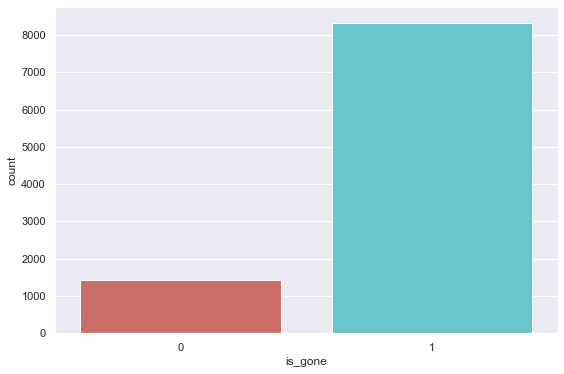

In [69]:
# Визуализируем:
sns.countplot(x='is_gone', data=users, palette='hls')

## Данные за первые N дней

In [70]:
# Нужно предсказать, что пользователь покинет курс как можно раньше, пока он еще здесь.
# Правда ли, что по поведению пользователя на курсе за первую неделю (или несколько дней)
# можно предсказать закончит он курс или нет?

# Попробуем порог в 3 дня:

learning_time_threshold = 3 * 24 * 60 * 60

# Спойлер - чем больше дней - тем лучше предсказывают модели.

In [71]:
# Для каждого пользователя отберем события, которые с ним происходили в течение первых 3 дней:
events_train = events[events['user_id'].isin(users['user_id'])]
events_train = events_train.merge(first_visits, on='user_id')
events_train = events_train.query("timestamp - first_visit <= @learning_time_threshold")
events_train

,step_id,timestamp,action,user_id,date,first_visit
0,32815,1434341931,passed,12494,2015-06-15,1434341931
1,32815,1434341931,discovered,12494,2015-06-15,1434341931
2,32815,1434341931,viewed,12494,2015-06-15,1434341931
3,32811,1434341937,viewed,12494,2015-06-15,1434341931
4,32811,1434341937,passed,12494,2015-06-15,1434341931
...,...,...,...,...,...,...
2191678,34004,1525214077,viewed,5573,2018-05-01,1524955364
2191679,34004,1525214077,discovered,5573,2018-05-01,1524955364
2191680,33896,1525214489,passed,5573,2018-05-01,1524955364
2191681,33896,1525214489,viewed,5573,2018-05-01,1524955364


In [72]:
# Проверим, что данные действительно за 3 дня:
events_train.groupby('user_id').date.nunique().max()

4

In [73]:
# Для каждого пользователя отберем сабмиты, которые они отправляли в течение первых 3 дней:
submissions_train = submissions[submissions['user_id'].isin(users['user_id'])]
submissions_train = submissions_train.merge(first_visits, on='user_id')
submissions_train = submissions_train.query('timestamp - first_visit <= @learning_time_threshold')
submissions_train

,step_id,timestamp,submission_status,user_id,date,first_visit
0,31971,1434349275,correct,15853,2015-06-15,1434345977
1,31972,1434348300,correct,15853,2015-06-15,1434345977
4,31976,1434348123,wrong,15853,2015-06-15,1434345977
5,31976,1434348188,correct,15853,2015-06-15,1434345977
7,31977,1434347371,correct,15853,2015-06-15,1434345977
...,...,...,...,...,...,...
330465,120745,1476419925,wrong,10312,2016-10-14,1476417044
330466,120745,1476419953,correct,10312,2016-10-14,1476417044
330467,120745,1476767714,correct,21817,2016-10-18,1476767576
330470,120745,1478563508,correct,26766,2016-11-08,1478561209


In [74]:
# Проверим, что данные действительно за 3 дня:
submissions_train.groupby('user_id').date.nunique().max()

4

In [75]:
# Соберем X:
X = users[['user_id','is_gone']]

# Посчитаем количество уникальных дней, в которые пользователь решал задачи:
days_of_training = submissions_train.groupby('user_id').date.nunique().to_frame() \
    .rename(columns={'date': 'days_of_training'})

# Посчитаем количество задач, которые пользователь попробовал решить:
steps_tried = submissions_train.groupby('user_id').step_id.nunique().to_frame() \
    .rename(columns={'step_id': 'tasks_tried'})

# Посчитаем количество правильных и неправильных ответов:
submission_statuses = submissions_train.pivot_table(
    index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
)

# Посчитаем количество просмотренных шагов:
viewed = events_train.pivot_table(
    index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)[['user_id', 'viewed']]

X = X.merge(days_of_training, on='user_id', how='outer')
X = X.merge(steps_tried, on='user_id', how='outer')
X = X.merge(submission_statuses, on='user_id', how='outer')
X = X.merge(viewed, on='user_id')
X

,user_id,is_gone,days_of_training,tasks_tried,correct,wrong,viewed
0,1,1,NaN,NaN,NaN,NaN,1
1,3,1,1.0,4.0,4.0,4.0,20
2,14,1,1.0,1.0,0.0,1.0,9
3,16,0,3.0,23.0,23.0,27.0,132
4,17,1,1.0,1.0,0.0,2.0,13
...,...,...,...,...,...,...,...
9756,26779,0,2.0,13.0,13.0,5.0,44
9757,26781,0,NaN,NaN,NaN,NaN,6
9758,26783,1,1.0,2.0,2.0,0.0,20
9759,26789,1,NaN,NaN,NaN,NaN,2


In [76]:
# Рассчитаем процент правильных ответов:
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])

# Заполним ячейки со значением "Nan" нулями:
X = X.fillna(0)

# Конвертируем значения в целые числа:
for col in ['days_of_training', 'tasks_tried', 'correct', 'wrong']:
    X[col] = X[col].map(int)

# Сделаем индекс по ID пользователя:
X = X.rename_axis('', axis=1).set_index('user_id')
X

,is_gone,days_of_training,tasks_tried,correct,wrong,viewed,correct_ratio
user_id,,,,,,,
1,1,0,0,0,0,1,0.000000
3,1,1,4,4,4,20,0.500000
14,1,1,1,0,1,9,0.000000
16,0,3,23,23,27,132,0.460000
17,1,1,1,0,2,13,0.000000
...,...,...,...,...,...,...,...
26779,0,2,13,13,5,44,0.722222
26781,0,0,0,0,0,6,0.000000
26783,1,1,2,2,0,20,1.000000


In [77]:
# Не знаю почему, но если конвертировать количественные переменные в градационные,
# то точность у дерева решений станет выше на 1 процент, может это совпадение.
# Видел как делали такое здесь: https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook
# А регрессия работает хуже на градационных переменных.
# Поэтому не применяю этот метод.

# for col in ['tasks_tried', 'correct', 'wrong', 'viewed', 'correct_ratio']:
#     col_band = col + '_band'
#     X[col_band] = pd.cut(X[col], 5)
#     band_tmp = X[['is_gone', col_band]].groupby(col_band, as_index=False).mean()

#     for index, row in band_tmp.iterrows():
#         X.loc[(X[col] > row[col_band].left) & \
#               (X[col] <= row[col_band].right), col] = index

#     X = X.drop(col_band, axis=1)

In [78]:
# Соберем y:
y = X['is_gone']

# Удалим колонку "is_gone" из X:
X = X.drop(['is_gone'], axis=1)
X

,days_of_training,tasks_tried,correct,wrong,viewed,correct_ratio
user_id,,,,,,
1,0,0,0,0,1,0.000000
3,1,4,4,4,20,0.500000
14,1,1,0,1,9,0.000000
16,3,23,23,27,132,0.460000
17,1,1,0,2,13,0.000000
...,...,...,...,...,...,...
26779,2,13,13,5,44,0.722222
26781,0,0,0,0,6,0.000000
26783,1,2,2,0,20,1.000000


## Пробуем модели

In [79]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

In [80]:
# Разделим данные на тренировочные и тестовые 2 к 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [81]:
X_train.shape

(6539, 6)

In [82]:
X_test.shape

(3222, 6)

## Дерево решений

In [93]:
# Найдем найлучшую глубину дерева решений:
grid_search_cv_clf = GridSearchCV(
    tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, random_state=0),
    {'max_depth': range(1, 5)},
    cv=5
)

In [94]:
# Обучим модель:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              min_samples_leaf=10,
                                              random_state=0),
             param_grid={'max_depth': range(1, 5)})

In [95]:
# Посмотрим лучшую модель:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=10,
                       random_state=0)

In [96]:
# Посмотрим точность на тестовых данных:
best_clf.score(X_test, y_test)

0.8774053382991931

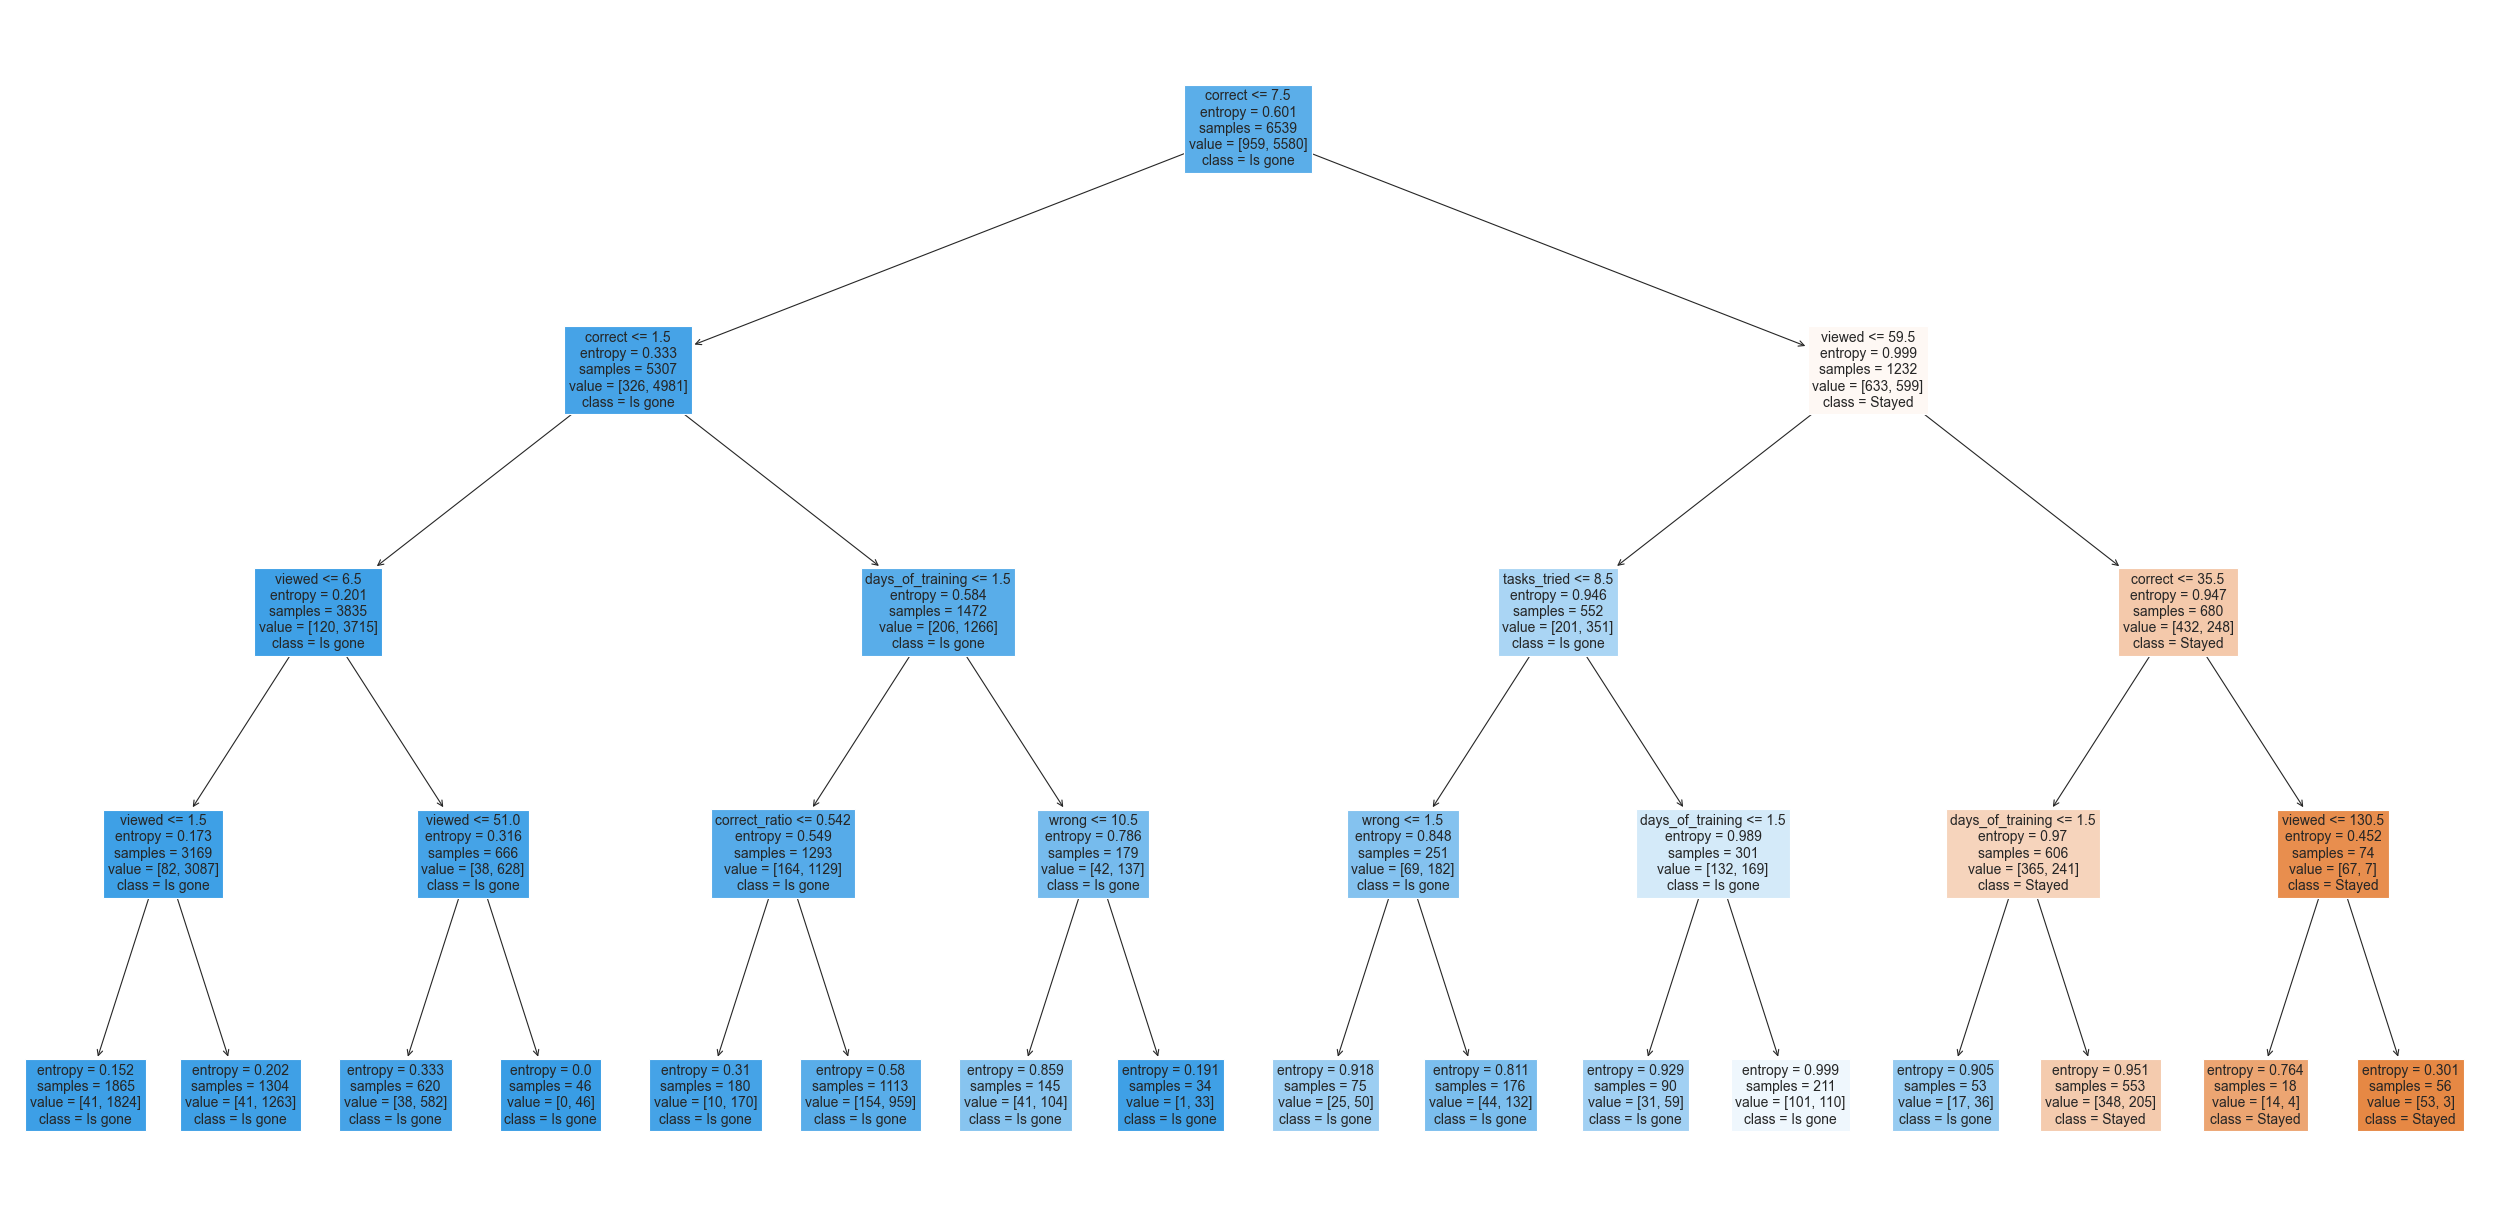

In [97]:
# Визуализируем дерево решений:
plt.figure(figsize=(40, 20), dpi=80)
tree.plot_tree(best_clf, feature_names=X.columns ,filled=True, class_names=['Stayed', 'Is gone']);

## Логистическая регрессия

In [98]:
# Обучим модель:
clf = LogisticRegressionCV(cv=5, random_state=0)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=5, random_state=0)

In [99]:
# Посмотрим точность на тренировочных данных:
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.881020452093994

In [100]:
# Посмотрим точность на тестовых данных:
clf.score(X_test, y_test)

0.8811297330850404

In [101]:
# Точность наших моделей получаются на 3 процента лучше чем, модели,
# которая просто говорит, что каждый пользователь уйдет с курса.

## Есть ли такой шаг, о который многие "споткнулись" и покинули курс?

In [102]:
# Посмотрим какой степ (в событиях) был для большинства пользователей последним:
events.merge(last_visits, on='user_id').query('timestamp == last_visit') \
    .groupby('step_id', as_index=False) \
    .agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'count'}) \
    .sort_values('count', ascending=False) \
    .head(10)

,step_id,count
58,32815,3396
60,32927,2098
39,32191,1914
64,32950,1247
59,32816,1076
68,32979,978
125,33537,836
4,31956,789
28,32176,772
149,33894,716


In [103]:
# Посмотрим какой степ (практические задания) был для большинства пользователей последним:
submissions.merge(last_visits, on='user_id').query('timestamp == last_visit') \
    .groupby('step_id', as_index=False) \
    .agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'count'}) \
    .sort_values('count', ascending=False) \
    .head(5)

# Создателям курса стоит обратить внимание на степы 32815, 32927, 32191.

,step_id,count
9,31991,51
4,31978,33
39,33669,22
3,31977,15
52,120745,14
